In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from sqlalchemy import create_engine
import pymysql
from pymysql.cursors import DictCursor
import pymysql.cursors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
username = 'root'          
password = ''               
host = 'localhost'         
port = '3306'              
database = 'top7_leagues' 

# Create the SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

In [3]:
query = "SELECT * FROM match_events_2023_24"
df_events = pd.read_sql(query, engine)

In [4]:
df_events.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name
0,2602361573,1734766,3,0,0.0,54,135366,50.1,50.0,46.4,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
1,2602361601,1734766,4,0,1.0,54,82989,46.1,49.7,31.9,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
2,2602361647,1734766,5,0,4.0,54,125211,31.8,13.1,20.8,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
3,2602361695,1734766,6,0,6.0,54,121456,20.8,30.8,20.1,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
4,2602361767,1734766,7,0,9.0,54,454342,19.4,64.2,18.1,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf


In [5]:
df_events['type_display_name'].unique()

array(['Pass', 'TakeOn', 'Foul', 'Aerial', 'BallRecovery', 'BlockedPass',
       'Interception', 'Dispossessed', 'Tackle', 'BallTouch', 'Challenge',
       'Clearance', 'CornerAwarded', 'Punch', 'MissedShots',
       'KeeperPickup', 'OffsidePass', 'OffsideProvoked', 'SavedShot',
       'Save', 'ShotOnPost', 'Goal', 'Card', 'SubstitutionOff',
       'SubstitutionOn', 'ShieldBallOpp', 'PenaltyFaced', 'Smother',
       'GoodSkill', 'Claim', 'CrossNotClaimed', 'KeeperSweeper', 'Error',
       'ChanceMissed', 'FormationChange'], dtype=object)

In [6]:
# Add the is_penalty column with default value 0
df_events['PenaltyFaced'] = np.where(df_events['type_display_name']=='PenaltyFaced',1,0)

In [7]:
df_events['event_after_pen'] = np.where(df_events['PenaltyFaced']==1, df_events['type_display_name'].shift(-1), 0)
df_events['event_before_pen'] = np.where(df_events['PenaltyFaced']==1, df_events['type_display_name'].shift(1), 0)

In [8]:
df_penalties = df_events[df_events['PenaltyFaced']==1]
df_penalties.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,PenaltyFaced,event_after_pen,event_before_pen
1561,2664554577,1729318,34,5,22.0,29,92516,0.0,0.0,NaN,...,NaN,0,0,0,PenaltyFaced,Unsuccessful,FirstHalf,1,Pass,Goal
2702,2664647995,1729318,603,76,44.0,29,20973,0.0,0.0,NaN,...,NaN,0,0,0,PenaltyFaced,Unsuccessful,SecondHalf,1,Goal,Foul
4026,2650604675,1741125,553,59,9.0,148,430870,0.0,0.0,NaN,...,NaN,0,0,0,PenaltyFaced,Unsuccessful,SecondHalf,1,Goal,Foul
6109,2629578175,1729498,1119,94,28.0,167,121774,0.0,0.0,NaN,...,NaN,0,0,0,PenaltyFaced,Unsuccessful,SecondHalf,1,SubstitutionOff,Goal
22837,2633026079,1748477,598,74,5.0,28635,463346,0.0,0.0,NaN,...,NaN,0,0,0,PenaltyFaced,Unsuccessful,SecondHalf,1,SavedShot,SubstitutionOn


In [9]:
relevant_events = ['Goal', 'SavedShot', 'MissedShots', 'ShotOnPost']
# Create the shift_1 DataFrame where 'event_after_pen' matches the relevant events
shift_1_after = df_penalties[df_penalties['event_after_pen'].isin(relevant_events)]
shift_1_before = df_penalties[df_penalties['event_before_pen'].isin(relevant_events)]

In [10]:
# Perform an outer merge on 'id' column, keeping all rows from df_events and merging the corresponding rows from shift_1_after
df_events = pd.merge(df_events, shift_1_after[['id', 'event_after_pen']], on='id', how='outer')
df_events = pd.merge(df_events, shift_1_before[['id', 'event_before_pen']], on='id', how='outer')

In [11]:
df_events.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,PenaltyFaced,event_after_pen_x,event_before_pen_x,event_after_pen_y,event_before_pen_y
0,2602361573,1734766,3,0,0.0,54,135366,50.1,50.0,46.4,...,0,0,Pass,Successful,FirstHalf,0,0,0,NaN,NaN
1,2602361601,1734766,4,0,1.0,54,82989,46.1,49.7,31.9,...,0,0,Pass,Successful,FirstHalf,0,0,0,NaN,NaN
2,2602361647,1734766,5,0,4.0,54,125211,31.8,13.1,20.8,...,0,0,Pass,Successful,FirstHalf,0,0,0,NaN,NaN
3,2602361695,1734766,6,0,6.0,54,121456,20.8,30.8,20.1,...,0,0,Pass,Successful,FirstHalf,0,0,0,NaN,NaN
4,2602361767,1734766,7,0,9.0,54,454342,19.4,64.2,18.1,...,0,0,Pass,Successful,FirstHalf,0,0,0,NaN,NaN


In [12]:
# First, initialize the is_penalty column to NaN (or 0, if you prefer)
df_events['is_penalty'] = 0

# Step 1: Mark the row *after* event_after_pen_y is not NaN
df_events['is_penalty'] = np.where(df_events['event_after_pen_y'].notna().shift(1), 1, df_events['is_penalty'])

# Step 2: Mark the row *before* event_before_pen_y is not NaN
df_events['is_penalty'] = np.where(df_events['event_before_pen_y'].notna().shift(-1), 1, df_events['is_penalty'])

In [13]:
# Correct list of columns to drop
col_to_drop = ['PenaltyFaced', 'event_after_pen_x', 'event_before_pen_x', 'event_after_pen_y', 'event_before_pen_y']
# Drop the columns from df_events
df_events = df_events.drop(columns=col_to_drop)

In [14]:
df_events.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,is_penalty
0,2602361573,1734766,3,0,0.0,54,135366,50.1,50.0,46.4,...,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,1
1,2602361601,1734766,4,0,1.0,54,82989,46.1,49.7,31.9,...,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0
2,2602361647,1734766,5,0,4.0,54,125211,31.8,13.1,20.8,...,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0
3,2602361695,1734766,6,0,6.0,54,121456,20.8,30.8,20.1,...,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0
4,2602361767,1734766,7,0,9.0,54,454342,19.4,64.2,18.1,...,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf,0


In [15]:
# Apply transformations to x and y coordinates
for col in ['x', 'end_x','blocked_x']:
    df_events.loc[:, col] *= 1.2
for col in ['y', 'end_y', 'blocked_y', 'goal_mouth_y']:
    df_events.loc[:, col] = 80 - (df_events[col] * 0.8)

In [19]:
df_shots = df_events[df_events['is_shot']==1]

In [20]:
df_shots.columns

Index(['id', 'match_id', 'event_id', 'minute', 'second', 'team_id',
       'player_id', 'x', 'y', 'end_x', 'end_y', 'qualifiers', 'is_touch',
       'blocked_x', 'blocked_y', 'goal_mouth_z', 'goal_mouth_y', 'is_shot',
       'card_type', 'is_goal', 'type_display_name',
       'outcome_type_display_name', 'period_display_name', 'is_penalty'],
      dtype='object')

In [21]:
columns_to_drop = ['id', 'match_id', 'event_id', 'second','team_id', 'player_id', 
                   'qualifiers', 'card_type', 'outcome_type_display_name','is_touch',
                   'period_display_name','end_x','end_y']
df_shots = df_shots.drop(columns=columns_to_drop)

In [22]:
df_shots['type_display_name'].unique()

array(['MissedShots', 'SavedShot', 'ShotOnPost', 'Goal'], dtype=object)

In [23]:
# Mapping logic: 1 = on target, 0 = off target
df_shots['is_on_target'] = df_shots['type_display_name'].map({
    'MissedShots': 0,
    'SavedShot': 1,
    'ShotOnPost': 0,
    'Goal': 1
})

In [24]:
df_shots['was_blocked'] = df_shots['blocked_x'].notna().astype(int)

In [25]:
df_shots['distance_blocker_goal'] = np.sqrt((df_shots['blocked_x'] - 120)**2 + (df_shots['blocked_y'] - 40)**2)
df_shots['distance_shooter_blocker'] = np.sqrt((df_shots['blocked_x'] - df_shots['x'])**2 + (df_shots['blocked_y'] - df_shots['y'])**2)

In [26]:
columns_to_drop = ['type_display_name','is_shot']
df_shots = df_shots.drop(columns=columns_to_drop)

In [27]:
df_shots.head()

,minute,x,y,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_goal,is_penalty,is_on_target,was_blocked,distance_blocker_goal,distance_shooter_blocker
75,4,117.48,47.68,NaN,NaN,72.2,46.64,0,0,0,0,NaN,NaN
217,12,97.32,41.92,117.72,40.16,5.1,41.84,0,0,1,1,2.285607,20.475781
296,17,110.04,35.60,NaN,NaN,6.9,33.60,0,0,0,0,NaN,NaN
305,17,107.40,35.60,NaN,NaN,80.6,37.12,0,0,0,0,NaN,NaN
395,23,108.12,22.88,NaN,NaN,5.7,44.48,0,0,0,0,NaN,NaN


In [28]:
# Goal center coordinates
goal_x = 120
goal_y = 40

# Calculate shot distance
df_shots['shot_distance'] = np.sqrt((df_shots['x'] - goal_x)**2 + (df_shots['y'] - goal_y)**2)

# Calculate shot angle in radians
df_shots['shot_angle'] = np.arctan2(np.abs(df_shots['y'] - goal_y), np.abs(goal_x - df_shots['x']))

# Convert angle to degrees (optional)
df_shots['shot_angle_deg'] = np.degrees(df_shots['shot_angle'])

In [29]:
# Drop the 'shot_angle' column
df_shots = df_shots.drop(columns=['shot_angle'])

In [30]:
df_shots.head()

,minute,x,y,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_goal,is_penalty,is_on_target,was_blocked,distance_blocker_goal,distance_shooter_blocker,shot_distance,shot_angle_deg
75,4,117.48,47.68,NaN,NaN,72.2,46.64,0,0,0,0,NaN,NaN,8.082871,71.834043
217,12,97.32,41.92,117.72,40.16,5.1,41.84,0,0,1,1,2.285607,20.475781,22.761125,4.838899
296,17,110.04,35.60,NaN,NaN,6.9,33.60,0,0,0,0,NaN,NaN,10.888600,23.834263
305,17,107.40,35.60,NaN,NaN,80.6,37.12,0,0,0,0,NaN,NaN,13.346160,19.249526
395,23,108.12,22.88,NaN,NaN,5.7,44.48,0,0,0,0,NaN,NaN,20.838157,55.242243


In [71]:
df_shots.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62349 entries, 75 to 3620556
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   minute                    62349 non-null  int64   
 1   x                         62349 non-null  float64 
 2   y                         62349 non-null  float64 
 3   blocked_x                 35142 non-null  float64 
 4   blocked_y                 35142 non-null  float64 
 5   goal_mouth_z              62349 non-null  float64 
 6   goal_mouth_y              62349 non-null  float64 
 7   is_goal                   62349 non-null  int64   
 8   is_penalty                62349 non-null  int64   
 9   is_on_target              62349 non-null  int64   
 10  was_blocked               62349 non-null  int64   
 11  distance_blocker_goal     35142 non-null  float64 
 12  distance_shooter_blocker  35142 non-null  float64 
 13  shot_distance             62349 non-null  float6

In [48]:
df_shots = df_shots.drop(columns=['Distance_Bins','Angle_Bins'])

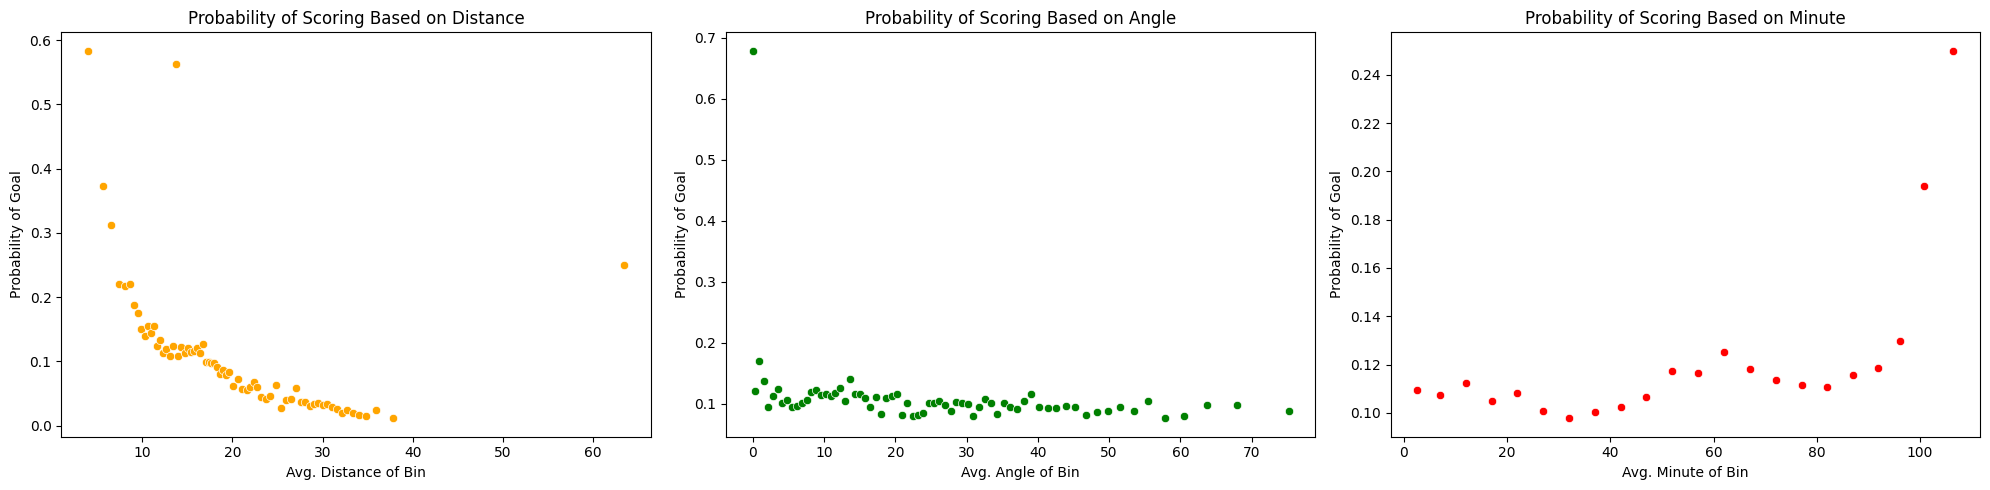

In [69]:
# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1. Probability of Scoring Based on Distance
df_shots['Distance_Bins'] = pd.qcut(df_shots['shot_distance'], q=70)
dist_prob = df_shots.groupby('Distance_Bins', as_index=False)['is_goal'].mean()
dist_mean = df_shots.groupby('Distance_Bins', as_index=False)['shot_distance'].mean()
sns.scatterplot(x=dist_mean['shot_distance'], y=dist_prob['is_goal'], ax=axes[0], color="orange")
axes[0].set_xlabel("Avg. Distance of Bin")
axes[0].set_ylabel("Probability of Goal")
axes[0].set_title("Probability of Scoring Based on Distance")

# 2. Probability of Scoring Based on Angle
df_shots['Angle_Bins'] = pd.qcut(df_shots['shot_angle_deg'], q=70)
angle_prob = df_shots.groupby('Angle_Bins', as_index=False)['is_goal'].mean()
angle_mean = df_shots.groupby('Angle_Bins', as_index=False)['shot_angle_deg'].mean()
sns.scatterplot(x=angle_mean['shot_angle_deg'], y=angle_prob['is_goal'], ax=axes[1], color="green")
axes[1].set_xlabel("Avg. Angle of Bin")
axes[1].set_ylabel("Probability of Goal")
axes[1].set_title("Probability of Scoring Based on Angle")

# 3. Probability of Scoring Based on Minute
minute_bins = np.linspace(df_shots['minute'].min(), df_shots['minute'].max(), 23)
df_shots['Minute_Bins'] = pd.cut(df_shots['minute'], bins=minute_bins)
minute_prob = df_shots.groupby('Minute_Bins', as_index=False)['is_goal'].mean()
minute_mean = df_shots.groupby('Minute_Bins', as_index=False)['minute'].mean()
sns.scatterplot(x=minute_mean['minute'], y=minute_prob['is_goal'], ax=axes[2], color="red")
axes[2].set_xlabel("Avg. Minute of Bin")
axes[2].set_ylabel("Probability of Goal")
axes[2].set_title("Probability of Scoring Based on Minute")


plt.tight_layout()
plt.show()

In [72]:
df_shots.drop(columns=['Distance_Bins', 'Angle_Bins', 'Minute_Bins'], inplace=True)

In [131]:
# Fill missing values with -1 for distance-related features
df_shots['distance_blocker_goal'].fillna(-1, inplace=True)
df_shots['distance_shooter_blocker'].fillna(-1, inplace=True)

# For blocked_x and blocked_y, you can also use -1 if you want to distinguish them from valid values
df_shots['blocked_x'].fillna(0, inplace=True)
df_shots['blocked_y'].fillna(0, inplace=True)

In [143]:
# Define features and target
features = ['x','y','goal_mouth_z',
             'is_penalty', 'was_blocked', 'distance_blocker_goal',
             'distance_shooter_blocker', 'shot_distance', 'shot_angle_deg']
target = 'is_goal'

# Define feature matrix and target vector
X = df_shots[features]
y = df_shots[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [144]:
print(y_train.value_counts())

is_goal
0    38799
1     4845
Name: count, dtype: int64


In [145]:
# Initialize and train the model
model = LogisticRegression(max_iter=100)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     16638
           1       0.63      0.43      0.51      2067

    accuracy                           0.91     18705
   macro avg       0.78      0.70      0.73     18705
weighted avg       0.90      0.91      0.90     18705

ROC AUC Score: 0.9400435657894715


Confusion Matrix:
 [[16111   527]
 [ 1181   886]]


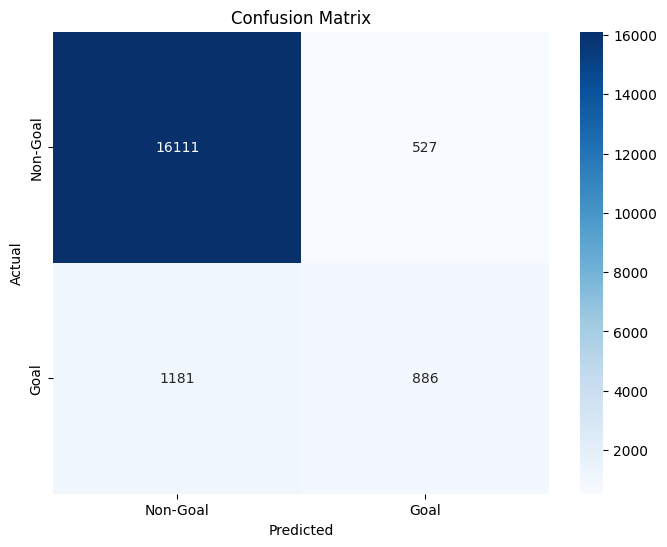

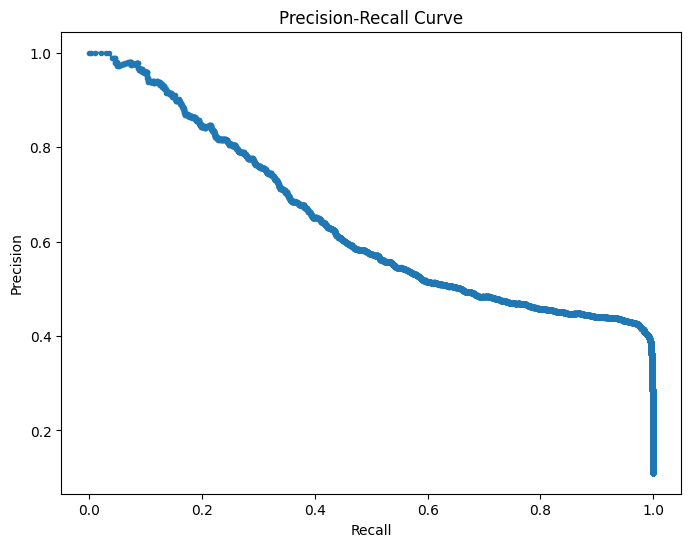

In [146]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Goal', 'Goal'], yticklabels=['Non-Goal', 'Goal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()